# Nonlinear vs. Linear Convolutional Networks applied to Fashion MNIST

Here we use a simple implementation of a quadratic convolutional layer in a neural network applied to the Fashion MNIST dataset and compare it to a standard linear convolutional network. The quadratic convolutions here were studied in [arXiv paper 1708.01038](https://arxiv.org/abs/1708.07038) although their implementation differs from ours in that here we do not take into account the symmetry of the associated quadratic form.

Note that this notebook assumes that you have downloaded the Fashion MNIST dataset to data directory specified below. To get the Fashion MNIST data set [see this github site](https://github.com/zalandoresearch/fashion-mnist)

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

tf.logging.set_verbosity(tf.logging.WARN)

from tensorflow.examples.tutorials.mnist import input_data

DATA_DIR = './data/fashion'

## Linear Convolutional Model

First we construct the linear model. This is the standard two linear convolutional layer model used in the Tensorflow tutorials. We then run the model for 100 epochs on the dataset.

In [2]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    # Computes 32 features using a 5x5 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 28, 28, 1]
    # Output Tensor Shape: [batch_size, 28, 28, 32]
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 28, 28, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2
    # Computes 64 features using a 5x5 filter.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 14, 14, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 64]
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 14, 14, 64]
    # Output Tensor Shape: [batch_size, 7, 7, 64]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 7, 7, 64]
    # Output Tensor Shape: [batch_size, 7 * 7 * 64]
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 1024]
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

    # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [10]:
# Load training and eval data
mnist = input_data.read_data_sets(DATA_DIR, one_hot=False, validation_size=0)

train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
train_data, train_labels = shuffle(train_data, train_labels)

eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
eval_data, eval_labels = shuffle(eval_data, eval_labels)

# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")

# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=400,
    num_epochs=None,
    shuffle=True)

    # Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)

baselineAccuracy = []

for j in tqdm_notebook(range(100)):
    mnist_classifier.train(
        input_fn=train_input_fn,
        steps=2000)

    eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
    baselineAccuracy.append(eval_results['accuracy'])

Extracting ./data/fashion/train-images-idx3-ubyte.gz
Extracting ./data/fashion/train-labels-idx1-ubyte.gz
Extracting ./data/fashion/t10k-images-idx3-ubyte.gz
Extracting ./data/fashion/t10k-labels-idx1-ubyte.gz


In [32]:
baselineAccuracy[-1]

0.9023

## Quadratic Model

Now that we have a baseline model, we construct a quadratic model to compare.

Here the main difference between the linear convolutional model and the quadratic convolutional model is the manipulation done to each patch of the input image. Normally, given a patch $x$, a linear convolution computes $$ w^T x + b, $$ where $w$ is the convolution kernel and $b$ is a bias term. In a quadratic convolutional layer, we instead compute $$ x^T Q x + w^T x + b, $$ where here $Q$ is a 'quadratic' kernel associated to the layer.

In [33]:
def quadratic_conv(inputs, W, input_dim, kernel_size, padding='SAME'):
    input_patches = tf.extract_image_patches(inputs, ksizes=[1, kernel_size[0], kernel_size[1], 1], strides=[1, 1, 1, 1], rates=[1, 1, 1, 1], padding=padding)
    batch, out_row, out_col, sizes = input_patches.get_shape().as_list()
    input_patches = tf.reshape(input_patches, [-1, out_row, out_col, kernel_size[0]*kernel_size[1], input_dim])
    V = tf.einsum('abcid,abcjd,dijo->abcdo', input_patches, input_patches, W)
    return tf.reduce_sum(V, 3)


def quadratic_layer(inputs, filters=32, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu):
    input_dim = inputs.get_shape().as_list()[-1]

    W1 = tf.Variable(tf.truncated_normal([input_dim, kernel_size[0]**2, kernel_size[1]**2, filters]))
    W2 = tf.Variable(tf.truncated_normal([kernel_size[0], kernel_size[1], input_dim, filters]))
    b  = tf.Variable(tf.constant(0.1, shape=[filters]))

    return activation(quadratic_conv(inputs, W1, input_dim, kernel_size, padding=padding) + tf.nn.conv2d(inputs, W2, strides=[1,1,1,1], padding=padding) + b)

In [34]:
def quadratic_model_fn(features, labels, mode):
    """Model function for Quadratic CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Quadratic Layer #1
    # Computes 32 features using a 3x3 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 28, 28, 1]
    # Output Tensor Shape: [batch_size, 28, 28, 32]
    conv1 = quadratic_layer(inputs=input_layer, filters=32, kernel_size=[3,3], padding='SAME', activation=tf.nn.relu)

    # Pooling Layer #1
    # First max pooling layer with a 4x4 filter and stride of 4
    # Input Tensor Shape: [batch_size, 28, 28, 32]
    # Output Tensor Shape: [batch_size, 7, 7, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[4, 4], strides=4)

    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 7, 7, 32]
    # Output Tensor Shape: [batch_size, 7 * 7 * 32]
    pool1_flat = tf.reshape(pool1, [-1, 7 * 7 * 32])

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 32]
    # Output Tensor Shape: [batch_size, 1024]
    dense = tf.layers.dense(inputs=pool1_flat, units=1024, activation=tf.nn.relu)

    # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [36]:
# Create the Estimator
mnist_quad_classifier = tf.estimator.Estimator(
    model_fn=quadratic_model_fn, model_dir="/tmp/mnist_quadnet_model")

# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=400,
    num_epochs=None,
    shuffle=True)

    # Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)

quadraticAccuracy = []

for j in tqdm_notebook(range(100)):
    mnist_quad_classifier.train(
        input_fn=train_input_fn,
        steps=2000)

    eval_results = mnist_quad_classifier.evaluate(input_fn=eval_input_fn)
    quadraticAccuracy.append(eval_results['accuracy'])

## Comparison

Lastly, we briefly compare the accuracy of the two models over 100 epochs. Of course, much more testing should be done, such as running both models for an extended number of epochs, experimenting with multi layer quadratic networks, etc.

In [46]:
x_axis = [i for i in range(100)]

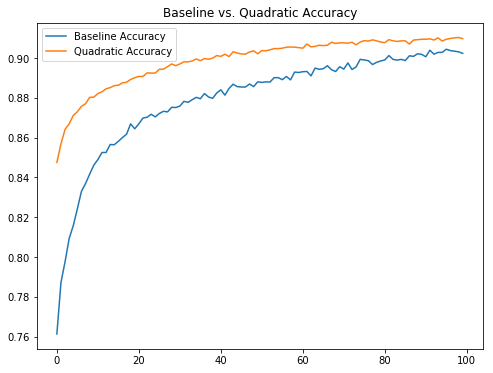

In [48]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x_axis, baselineAccuracy, label='Baseline Accuracy')
ax.plot(x_axis, quadraticAccuracy, label='Quadratic Accuracy')

ax.set_title(r'Baseline vs. Quadratic Accuracy')
ax.legend(loc=2)